### Import the required modules

In [2]:
import os
import pickle
import math
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from bayes_opt import BayesianOptimization

# Keras modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv3D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

/home/poc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Pre-process the Dataset

In [3]:


# Load the datasets
sample_full_data = loadmat('Data_S3_86_68_7_78.mat')
print(sample_full_data)
X_train_orig = sample_full_data['Data']
Y_train_orig = sample_full_data['Age']

# Print details of the orignal data
print("X_train_orig shape: " + str(X_train_orig.shape))
print("Y_train_orig shape: " + str(Y_train_orig.shape), "\n")

# Reshape the input data for keras
split_fraction = 0.9     # should be greater than 0.5
# X_train = np.array([ X_train_orig[:, :, :, :, i] for i in range(len(Y_train)) ])
train_set_len = math.ceil((X_train_orig.shape[4]) * split_fraction)
test_set_len = X_train_orig.shape[4] - train_set_len
X_train = np.zeros((train_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2], X_train_orig.shape[3]))
X_test = np.zeros((test_set_len, X_train_orig.shape[0], X_train_orig.shape[1], X_train_orig.shape[2], X_train_orig.shape[3]))
Y_train = np.zeros((train_set_len, 1))
Y_test = np.zeros((test_set_len, 1))

# Split into train and test, by the given split fraction
for i in range(train_set_len + test_set_len):
    if i < train_set_len:
        X_train[i] = X_train_orig[:, :, :, :, i]
        Y_train[i] = Y_train_orig[i]
        
    else:
        X_test[i - train_set_len] = X_train_orig[:, :, :, :, i]
        Y_test[i - train_set_len] = Y_train_orig[i]

# Print details of the reshaped data
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jun 17 11:31:36 2019', '__version__': '1.0', '__globals__': [], 'Age': array([[1687],
       [ 754],
       [ 498],
       [ 362],
       [ 103],
       [ 185],
       [1241],
       [ 306],
       [1390],
       [ 749],
       [ 263],
       [ 229],
       [ 276],
       [ 672],
       [1111],
       [  80],
       [1189],
       [1144],
       [1494],
       [1543],
       [1372],
       [1449],
       [1502],
       [1511],
       [1779],
       [1263],
       [1202],
       [  57],
       [1028],
       [1612],
       [ 906],
       [1403],
       [1405],
       [1613],
       [ 618],
       [ 172],
       [ 645],
       [ 243],
       [ 288],
       [ 239],
       [ 846],
       [ 268],
       [ 680],
       [1794],
       [1352],
       [1529],
       [ 463],
       [1298],
       [ 189],
       [1725],
       [  14],
       [1751],
       [1686],
       [1609],
       [1326],
       [1026],
       [ 146],
 

### Example of an Image

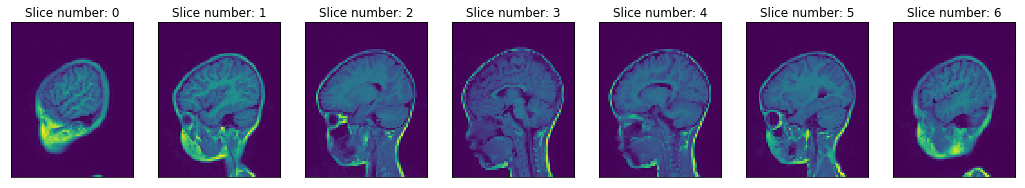

y = 1241.0


In [4]:
index = 6    # just some image for preview

fig, ax = plt.subplots(1, 7, figsize=[18, 3])
for i in range(X_train.shape[-2]):
    ax[i].imshow(X_train[index, :, :, i, 0])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('Slice number: {}'.format(i))
plt.show()

print("y = " + str(np.squeeze(Y_train[index, :])))

### 1.1 - Create a Model

In [5]:
def create_model(lr=0.001, beta_1=0.9):
    try:
        del model
    except:
        pass

    # Create a model
    model = Sequential()

    # Add a convolutional layer
    model.add(Conv3D(filters=16, kernel_size=5, strides=(1, 1, 1), padding='same', input_shape=(86, 68, 7, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid'))

    # Add a convolution layer
    model.add(Conv3D(filters=64, kernel_size=3, strides=(1, 1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid'))

    # Flatten the output
    model.add(Flatten())

    # Add a dense layer
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    # Add another dense layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    
    # Add output node
    model.add(Dense(1))
    model.add(Activation('linear'))
    optAdam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optAdam,
                  loss='mean_squared_error')
    return model

### Training the Model

In [6]:
lr_list = np.array([5**-5])
mom_list = np.array([0.9])

g_grid = np.meshgrid(lr_list, mom_list)
g_grid_points = np.append(g_grid[0].reshape(-1,1), g_grid[1].reshape(-1,1), axis=1)

g_result_list = []
for i in g_grid_points:
    model = create_model(lr=i[0], beta_1=i[1])
    model.fit(
        x=X_train,
        y=Y_train,
        epochs=500)
    score = model.evaluate(X_test, Y_test, verbose = 0)
    g_result_list.append([i[0], i[1], score])

for i in g_result_list:
    print("For learning rate = {0} and momentum = {1}: mean squared error = {2}".format(i[0], i[1], i[2]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
71/71 [==============================] - 23s 317ms/step - loss: 1212685.9437
Epoch 2/500
71/71 [==============================] - 19s 261ms/step - loss: 605950.2016
Epoch 3/500
71/71 [==============================] - 20s 275ms/step - loss: 313652.2188
Epoch 4/500
71/71 [==============================] - 21s 289ms/step - loss: 411758.7386
Epoch 5/500
71/71 [==============================] - 25709s 362s/step - loss: 242186.7414
Epoch 6/500
71/71 [==============================] - 20s 277ms/step - loss: 296476.9415
Epoch 7/500
71/71 [==============================] - 19s 267ms/step - loss: 293124.4177
Epoch 8/500
71/71 [==============================] - 24s 334ms/step - loss: 224899.6441
Epoch 9/500
71/71 [==============================] - 25s 347ms/step - loss: 199580.6358
Epoch 10/500
71/71 [==============================] - 22s 313ms/step - loss: 216416.6

71/71 [==============================] - 17s 245ms/step - loss: 11075.4353
Epoch 88/500
71/71 [==============================] - 17s 245ms/step - loss: 7918.3756
Epoch 89/500
71/71 [==============================] - 17s 245ms/step - loss: 7501.1585
Epoch 90/500
71/71 [==============================] - 17s 245ms/step - loss: 7132.3922
Epoch 91/500
71/71 [==============================] - 17s 245ms/step - loss: 7052.6076
Epoch 92/500
71/71 [==============================] - 17s 245ms/step - loss: 8957.1969
Epoch 93/500
71/71 [==============================] - 17s 245ms/step - loss: 7267.1967
Epoch 94/500
71/71 [==============================] - 17s 245ms/step - loss: 6125.8417
Epoch 95/500
71/71 [==============================] - 17s 244ms/step - loss: 5152.4138
Epoch 96/500
71/71 [==============================] - 17s 245ms/step - loss: 8100.3560
Epoch 97/500
71/71 [==============================] - 17s 245ms/step - loss: 7836.2036
Epoch 98/500
71/71 [==============================] - 1

71/71 [==============================] - 17s 245ms/step - loss: 185.4752
Epoch 181/500
71/71 [==============================] - 17s 244ms/step - loss: 258.0413
Epoch 182/500
71/71 [==============================] - 17s 245ms/step - loss: 171.3651
Epoch 183/500
71/71 [==============================] - 17s 245ms/step - loss: 275.3163
Epoch 184/500
71/71 [==============================] - 17s 245ms/step - loss: 375.8914
Epoch 185/500
71/71 [==============================] - 17s 245ms/step - loss: 270.3307
Epoch 186/500
71/71 [==============================] - 17s 245ms/step - loss: 244.5966
Epoch 187/500
71/71 [==============================] - 17s 245ms/step - loss: 251.5719
Epoch 188/500
71/71 [==============================] - 17s 244ms/step - loss: 165.0482
Epoch 189/500
71/71 [==============================] - 17s 245ms/step - loss: 137.2753
Epoch 190/500
71/71 [==============================] - 17s 245ms/step - loss: 74.7332
Epoch 191/500
71/71 [==============================] - 17s

71/71 [==============================] - 17s 246ms/step - loss: 7.8097
Epoch 276/500
71/71 [==============================] - 17s 245ms/step - loss: 6.4984
Epoch 277/500
71/71 [==============================] - 17s 245ms/step - loss: 3.8422
Epoch 278/500
71/71 [==============================] - 17s 245ms/step - loss: 2.3008
Epoch 279/500
71/71 [==============================] - 17s 245ms/step - loss: 2.8179
Epoch 280/500
71/71 [==============================] - 17s 245ms/step - loss: 2.5669
Epoch 281/500
71/71 [==============================] - 17s 245ms/step - loss: 2.3775
Epoch 282/500
71/71 [==============================] - 17s 245ms/step - loss: 1.9146
Epoch 283/500
71/71 [==============================] - 17s 245ms/step - loss: 1.6743
Epoch 284/500
71/71 [==============================] - 17s 245ms/step - loss: 1.8077
Epoch 285/500
71/71 [==============================] - 17s 245ms/step - loss: 1.7444
Epoch 286/500
71/71 [==============================] - 17s 245ms/step - loss: 2

71/71 [==============================] - 17s 245ms/step - loss: 0.1231
Epoch 372/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1225
Epoch 373/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1440
Epoch 374/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1027
Epoch 375/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1161
Epoch 376/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1538
Epoch 377/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1160
Epoch 378/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1071
Epoch 379/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1036
Epoch 380/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1077
Epoch 381/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0972
Epoch 382/500
71/71 [==============================] - 17s 245ms/step - loss: 0

71/71 [==============================] - 17s 245ms/step - loss: 0.0625
Epoch 468/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0600
Epoch 469/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0814
Epoch 470/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1243
Epoch 471/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0755
Epoch 472/500
71/71 [==============================] - 17s 246ms/step - loss: 0.0527
Epoch 473/500
71/71 [==============================] - 17s 245ms/step - loss: 0.1516
Epoch 474/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0254
Epoch 475/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0231
Epoch 476/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0268
Epoch 477/500
71/71 [==============================] - 17s 245ms/step - loss: 0.0321
Epoch 478/500
71/71 [==============================] - 17s 245ms/step - loss: 0

### Making Prediction

In [7]:
output = model.predict(X_test)
for i, j in enumerate(X_test):
    print("For sample test sample {0}: True Output = {1} and Prediction = {2} error = {3}".format(i, Y_test[i], output[i], Y_test[i] - output[i]))

For sample test sample 0: True Output = [1499.] and Prediction = [1747.5079] error = [-248.50793457]
For sample test sample 1: True Output = [1682.] and Prediction = [803.50543] error = [878.49456787]
For sample test sample 2: True Output = [132.] and Prediction = [215.69724] error = [-83.69723511]
For sample test sample 3: True Output = [315.] and Prediction = [230.69852] error = [84.30148315]
For sample test sample 4: True Output = [89.] and Prediction = [62.987293] error = [26.01270676]
For sample test sample 5: True Output = [76.] and Prediction = [93.045525] error = [-17.0455246]
For sample test sample 6: True Output = [1765.] and Prediction = [1662.048] error = [102.95202637]
